In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_predict
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import math
from sklearn.utils import shuffle
from sklearn.linear_model import Ridge
from sklearn.preprocessing import scale

In [4]:
file = os.getcwd()+"/../data/029720-99999_allYrs_Avg.txt"
dat = pd.read_csv(file,header=None,names=["lat", "lon", "elevation","date","dir","spd","gus","temp","slp"])
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp
0,60.514,22.263,49.1,19020101,2.199135,23.700998,***,30.200000,994.28
1,60.514,22.263,49.1,19020102,2.443461,6.800000,***,17.200000,993.96
2,60.514,22.263,49.1,19020103,2.208953,9.938701,***,-0.200000,1005.08
3,60.514,22.263,49.1,19020104,3.949456,23.453623,***,28.733333,985.386666667
4,60.514,22.263,49.1,19020105,4.417350,5.170652,***,30.466667,978.293333333


In [6]:
#switch date to datetime object
dat['date'] = pd.to_datetime(dat['date'],format = '%Y%m%d')
dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp
0,60.514,22.263,49.1,1902-01-01,2.199135,23.700998,***,30.200000,994.28
1,60.514,22.263,49.1,1902-01-02,2.443461,6.800000,***,17.200000,993.96
2,60.514,22.263,49.1,1902-01-03,2.208953,9.938701,***,-0.200000,1005.08
3,60.514,22.263,49.1,1902-01-04,3.949456,23.453623,***,28.733333,985.386666667
4,60.514,22.263,49.1,1902-01-05,4.417350,5.170652,***,30.466667,978.293333333


In [7]:
#Add more date columns for specific analyses
dat['year'] = pd.DatetimeIndex(dat['date']).year
dat['month'] = pd.DatetimeIndex(dat['date']).month
dat['day'] = pd.DatetimeIndex(dat['date']).day
dat['dayOfYear'] = pd.DatetimeIndex(dat['date']).dayofyear
dat['dir']=dat['dir']*(180/math.pi)


#Replace *** with NaN's 
dat = dat.replace('***',np.nan)

dat.head()

,lat,lon,elevation,date,dir,spd,gus,temp,slp,year,month,day,dayOfYear
0,60.514,22.263,49.1,1902-01-01,126.001139,23.700998,NaN,30.200000,994.28,1902,1,1,1
1,60.514,22.263,49.1,1902-01-02,140.000000,6.800000,NaN,17.200000,993.96,1902,1,2,2
2,60.514,22.263,49.1,1902-01-03,126.563681,9.938701,NaN,-0.200000,1005.08,1902,1,3,3
3,60.514,22.263,49.1,1902-01-04,226.287188,23.453623,NaN,28.733333,985.386666667,1902,1,4,4
4,60.514,22.263,49.1,1902-01-05,253.095503,5.170652,NaN,30.466667,978.293333333,1902,1,5,5


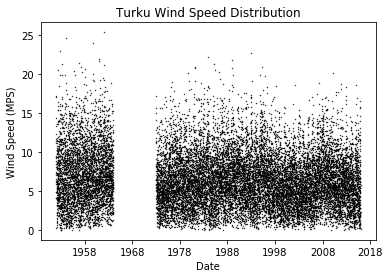

In [12]:
plt.plot_date(dat["date"], dat['spd'],marker = 'o',ms = .4,color='k')
plt.ylabel("Wind Speed (MPS)")
plt.xlabel("Date")
plt.title("Turku Wind Speed Distribution")
plt.show()

In [9]:
#Since the speed data pre-1950 seems a bit off
dat=dat[dat['year']>1950]

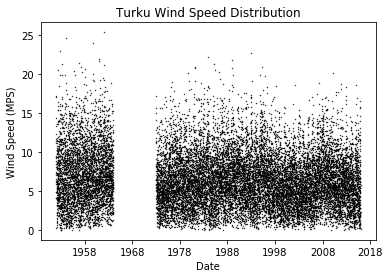

In [11]:
plt.plot_date(dat["date"], dat['spd'],marker = 'o',ms = .4,color='k')
plt.ylabel("Wind Speed (MPS)")
plt.xlabel("Date")
plt.title("Turku Wind Speed Distribution")
plt.show()

### We take only post 1950 data since the early part of the distribution looks off.  First we predict speed with the entire feature set.

In [16]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  2.5539020602315454



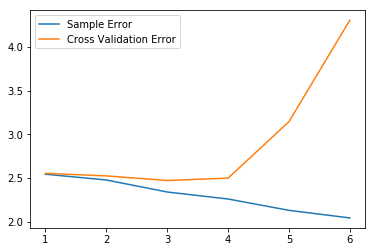

In [19]:
#Need to figure out what degree polynomial to use...
degreeList =[1,2,3,4,5,6]
#sqrt(MSE)
sampleError=[]
crossValidatedError = []
testError = []

df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]
for degree in degreeList:
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)
    lm = LinearRegression()
    lm.fit(X=X_train,y=y_train)
    
    #training set error
    y_predict = lm.predict(X_train)
    sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
plt.plot(degreeList,sampleError,label = "Sample Error")
plt.plot(degreeList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

# We'll use degree 3

In [21]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]
poly = PolynomialFeatures(degree = 3)
X_ = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

Cross validation sqrt(MSE) =  2.5539020602315454

% improvement =  0.03210242713522051


### We get a 3% improvement when we use polynomial features

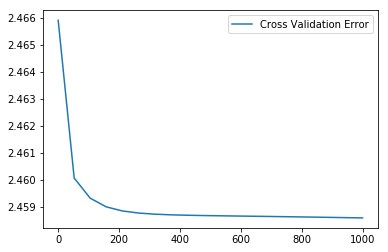

In [40]:
### Now we can try regularization
alphaList =np.linspace(0.01,1000,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]
for a in alphaList:
    poly = PolynomialFeatures(degree=3)
    X_ = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

### We'll use alpha of 800

In [52]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]
poly = PolynomialFeatures(degree = 3)
X_ = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 800)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  2.5539020602315454

% improvement =  0.03730380106370015
***************TEST BELOW****************
R^2 =  0.441991276716

RMSE for test =  2.459456025063229


### ------------------TEST above--------------------

### let's check if the mean does better


In [53]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

meany_train = np.zeros(len(y_train))
for i in range(len(meany_train)):
    meany_train[i]= np.mean(y_train)

RMSEcontrol=math.sqrt(mean_squared_error(meany_train,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

Cross validation sqrt(MSE) =  2.5539020602315454

% improvement =  0.03730380106370015


### This model does just as well as the ridge with high alpha implying that the model sucks!

### Let's see if any of the individual coefficients are important at all

In [54]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','dir','slp','month']]
y = df[['spd']]
scaledX = scale(X)
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

for idx, col_name in enumerate(X.columns):
    print("The coefficient for {} is {}".format(col_name, lm.coef_[0][idx]))

Cross validation sqrt(MSE) =  2.5539020602315454

The coefficient for gus is 2.1355359506963185
The coefficient for temp is -0.2308359198047655
The coefficient for dir is -0.360851147753671
The coefficient for slp is -0.010786084744740493
The coefficient for month is -0.010776136973421046


### Again, gust is the only significant coefficient

In [57]:
df = dat[['gus','spd']]
df = df.dropna()
X = df[['gus']]
y = df[['spd']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  2.639877048719171



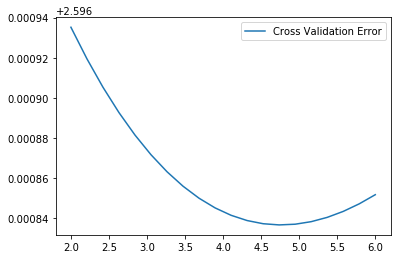

In [60]:
### Now we can try regularization
alphaList =np.linspace(2,6,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['gus','spd']]
df = df.dropna()
X = df[['gus']]
y = df[['spd']]
for a in alphaList:
    poly = PolynomialFeatures(degree=3)
    X_ = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

### We'll use an alpha value of 4.75

In [61]:
df = dat[['gus','spd']]
df = df.dropna()
X = df[['gus']]
y = df[['spd']]
poly = PolynomialFeatures(degree = 3)
X_ = poly.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 4.75)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  2.639877048719171

% improvement =  0.016303904582638234
***************TEST BELOW****************
R^2 =  0.417706808097

RMSE for test =  2.5662328147938473


### In this model we see that 42 percent of the variation can be explained by gust 

### ----------------TEST ABOVE-----------------

In [62]:
df = dat[['gus','spd']]
df = df.dropna()
X = df[['gus']]
y = df[['spd']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

meany_train = np.zeros(len(y_train))
for i in range(len(meany_train)):
    meany_train[i]= np.mean(y_train)

RMSEcontrol=math.sqrt(mean_squared_error(meany_train,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

Cross validation sqrt(MSE) =  2.639877048719171

% improvement =  0.016303904582638234


# Now we'll try to predict direction

In [63]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','spd','slp','month']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  82.44696862820416



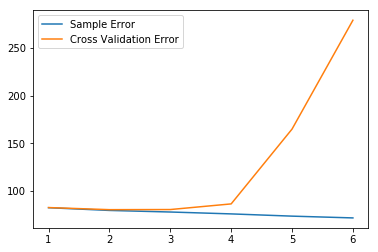

In [64]:
#Need to figure out what degree polynomial to use...
degreeList =[1,2,3,4,5,6]
#sqrt(MSE)
sampleError=[]
crossValidatedError = []
testError = []

df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','spd','slp','month']]
y = df[['dir']]
for degree in degreeList:
    poly = PolynomialFeatures(degree=degree)
    X_ = poly.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_, y, test_size=0.25, random_state=1,shuffle = True)
    lm = LinearRegression()
    lm.fit(X=X_train,y=y_train)
    
    #training set error
    y_predict = lm.predict(X_train)
    sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
plt.plot(degreeList,sampleError,label = "Sample Error")
plt.plot(degreeList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

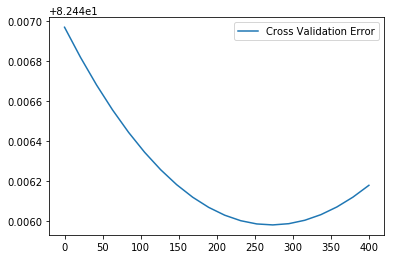

In [67]:
### Now we can try regularization
alphaList =np.linspace(0.01,400,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','spd','slp','month']]
y = df[['dir']]
for a in alphaList:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

### We'll use an alpha = 275

In [68]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','spd','slp','month']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 275)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  82.44696862820416

% improvement =  1.1961133274215771e-05
***************TEST BELOW****************
R^2 =  0.0257196967679

RMSE for test =  83.18333846118522


### Below we do the mean check

In [85]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','spd','slp','month']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

meany_train = np.zeros(len(y_train))
for i in range(len(meany_train)):
    meany_train[i]= np.mean(y_train)

RMSEcontrol=math.sqrt(mean_squared_error(meany_train,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

Cross validation sqrt(MSE) =  91.8258575192113

% improvement =  4.2061432503225276e-07


### --------------Test Above--------------------

In [70]:
df = dat[['gus','temp','dir','slp','month','spd']]
df = df.dropna()
X = df[['gus','temp','spd','slp','month']]
y = df[['dir']]
scaledX = scale(X)
X_train, X_test, y_train, y_test = train_test_split(scaledX, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

for idx, col_name in enumerate(X.columns):
    print("The coefficient for {} is {}".format(col_name, lm.coef_[0][idx]))

Cross validation sqrt(MSE) =  82.44696862820416

The coefficient for gus is 16.7714055830292
The coefficient for temp is -0.9707392911110801
The coefficient for spd is -14.944936549185469
The coefficient for slp is -5.4722246388737785
The coefficient for month is 1.5095574558736502


In [71]:
df = dat[['gus','dir']]
df = df.dropna()
X = df[['gus']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  81.93785846673218



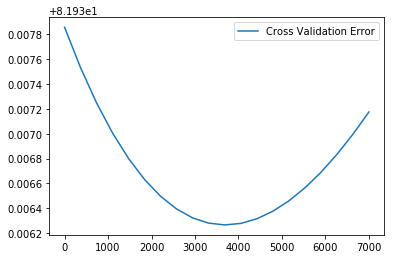

In [77]:
### Now we can try regularization
alphaList =np.linspace(0.01,7000,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['gus','dir']]
df = df.dropna()
X = df[['gus']]
y = df[['dir']]
for a in alphaList:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

# We'll use alpha = 3750

In [78]:
df = dat[['gus','dir']]
df = df.dropna()
X = df[['gus']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 3750)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  81.93785846673218

% improvement =  1.9445728072000493e-05
***************TEST BELOW****************
R^2 =  0.00254679981941

RMSE for test =  82.81641553838074


In [79]:
df = dat[['temp','dir']]
df = df.dropna()
X = df[['temp']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  91.8258575192113



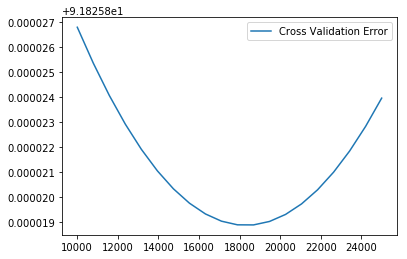

In [83]:
### Now we can try regularization
alphaList =np.linspace(10000,25000,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['temp','dir']]
df = df.dropna()
X = df[['temp']]
y = df[['dir']]
for a in alphaList:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

### We'll use alpha = 18000

In [84]:
df = dat[['temp','dir']]
df = df.dropna()
X = df[['temp']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 18000)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  91.8258575192113

% improvement =  4.2061432503225276e-07
***************TEST BELOW****************
R^2 =  0.0149740811403

RMSE for test =  91.26725736140577


In [93]:
df = dat[['spd','dir']]
df = df.dropna()
X = df[['spd']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  92.96576812195434



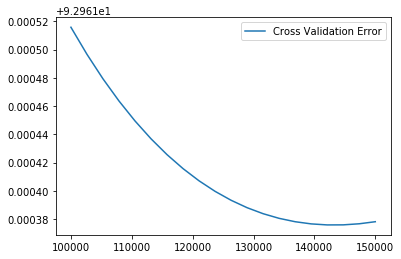

In [94]:
### Now we can try regularization
alphaList =np.linspace(100000,150000,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['spd','dir']]
df = df.dropna()
X = df[['spd']]
y = df[['dir']]
for a in alphaList:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

# We'll use alpha = 140000

In [95]:
df = dat[['spd','dir']]
df = df.dropna()
X = df[['spd']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 140000)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  92.96576812195434

% improvement =  4.723956362038877e-05
***************TEST BELOW****************
R^2 =  0.000133288224237

RMSE for test =  91.95222145078708


In [101]:
df = dat[['slp','dir']]
df = df.dropna()
X = df[['slp']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  92.71408167451264



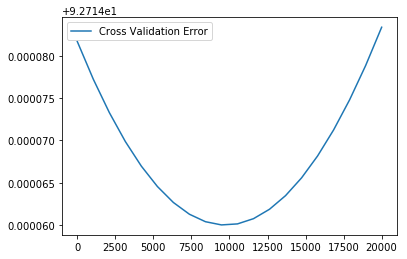

In [102]:
### Now we can try regularization
alphaList =np.linspace(1,20000,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['slp','dir']]
df = df.dropna()
X = df[['slp']]
y = df[['dir']]
for a in alphaList:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

# Use alpha = 10k

In [104]:
df = dat[['slp','dir']]
df = df.dropna()
X = df[['slp']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 10000)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  92.71408167451264

% improvement =  2.335469657823893e-07
***************TEST BELOW****************
R^2 =  0.00613454128888

RMSE for test =  92.69359276837336


In [105]:
df = dat[['month','dir']]
df = df.dropna()
X = df[['month']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = LinearRegression()
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
firstRMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()

Cross validation sqrt(MSE) =  92.97229025501944



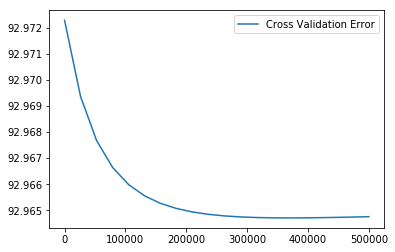

In [108]:
### Now we can try regularization
alphaList =np.linspace(1,500000,20)
#sqrt(MSE)
sampleError=[]
crossValidatedError = []


df = dat[['month','dir']]
df = df.dropna()
X = df[['month']]
y = df[['dir']]
for a in alphaList:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)
    lm = Ridge(alpha = a)
    lm.fit(X=X_train,y=y_train)
    
#     #training set error
#     y_predict = lm.predict(X_train)
#     sampleError.append(math.sqrt(mean_squared_error(y_predict,y_train)))
    
    #let's check the cross validated error
    y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
    crossValidatedError.append(math.sqrt(mean_squared_error(y_pred,y_train)))
    
  
#plt.plot(alphaList,sampleError,label = "Sample Error")
plt.plot(alphaList,crossValidatedError, label = "Cross Validation Error")
plt.legend()
plt.show()

### use alpha = 400k


In [109]:
df = dat[['month','dir']]
df = df.dropna()
X = df[['month']]
y = df[['dir']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1,shuffle = True)

lm = Ridge(alpha = 400000)
lm.fit(X=X_train, y = y_train)

#let's check the cross validated error
y_pred = cross_val_predict(lm,X_train,y_train,cv = 5)
RMSE=math.sqrt(mean_squared_error(y_pred,y_train))
print("Cross validation sqrt(MSE) = ",firstRMSE)
print()
print("% improvement = ",
     (firstRMSE - RMSE)/firstRMSE)

#TEST BELOW
score = lm.score(X=X_test, y = y_test)
print("***************TEST BELOW****************")
print("R^2 = ",score)
y_predict = lm.predict(X_test)
RMSEtest = math.sqrt(mean_squared_error(y_predict,y_test))
print()
print("RMSE for test = ",RMSEtest)

Cross validation sqrt(MSE) =  92.97229025501944

% improvement =  8.153848098149495e-05
***************TEST BELOW****************
R^2 =  -0.000249429328675

RMSE for test =  91.96981797732225
